In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from fastai.vision.all import *
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import albumentations as A

# Introduction
In this notebook, we hope to accomplish two primary things:
1) establish a system for drawing a *representative* sample of the dataset to facilitate rapid testing, possibly in combination with reductions to the size of the images; and
2) track experiments using [Weights and Biases](wandb.ai), particularly hyperparameters used between runs, in order to compare hyperparamter choices to accuracy across a large number of runs.

## Notes and Caveats
For (2) to work, we need to run this as an *online* notebook. We will endeavor to make this function *offline* as well as possible using conditionals throughout the notebook whenever `wandb` commands are invoked.

# Setting up Weights and Biases
1. Make a [free wandb account](wandb.ai).
2. Create a new project on wandb. After you create a new project, select `fast.ai` as your framework and you will be presented with instructions for getting started.
3. import `wandb`
4. `from fastai.callback.wandb import WandbCallback` (This allows fastai to communicate with/send metrics to `wandb`).
5. `from kaggle_secrets import UserSecretsClient` -- this will allow us to store our `wandb` API key in a way that is invisible to any other users.
6. Obtain your API key from the following link: https://wandb.ai/authorize. Copy it to the clipboard.
7. Go to `Add-ons` -> `Secrets` -> `Add a new secret`. Under `Label` put `WANDB_API_KEY`. Under `Value` paste the API key you copied to your clipboard. Make sure to check `Attach to Notebook`.

In [2]:
import wandb
from fastai.callback.wandb import WandbCallback
from kaggle_secrets import UserSecretsClient

8\. Save your secret to the environment:

In [3]:
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("WANDB_API_KEY")
os.environ["WANDB_API_KEY"] = secret_value_0
os.environ["WANDB_RUN_GROUP"] = "WANDB-EXAMPLE" # + wandb.util.generate_id() if you want a new random id for each run

We can, in this step, also define a "group name." This is useful for grouping all runs of a given notebook together in the `wandb` interface. See the cell above for details. You might consider putting this a bit later and conditially changing it whether you are doing a full run, subset, or test/debug run.

9\. Confirm that this worked by running `wandb.login()`. You can comment this out afterward. If it worked, you will see a message saying `wandb: Currently logged in as: {username} (use 'wandb login --relogin' to force relogin)`. It will output `False` if unsuccessful.

In [4]:
#wandb.login() #only first time and not in commit

10\. Define the hyperparameters you want to track. There are various ways to do this. In this case, we will be defining all of the hyperparameters of interest in a dictionary and passing that to the wandb config.
    
We are defining two config dictionaries: one which we will use when running the 'full' dataset and one for the smaller dataset which we will use for rapid iteration

In [5]:
TEST = True
RAPID = True

hyper_rapid = dict(
    TEST = TEST,
    FROZEN_EPOCHS = 1 if TEST else 5,
    UNFROZEN_EPOCHS = 1 if TEST else 12,
    BATCH_SIZE = 10 if TEST else 32,
    TEST_BATCH = 128,
    PROP_DATA = 0.15, # percentage of data to use
    PRESIZE = 512,
    MAX_ZOOM = 3.0
)
    
hyper_full = dict(
    TEST = TEST,
    FROZEN_EPOCHS = 2 if TEST else 5,
    UNFROZEN_EPOCHS = 2 if TEST else 5,
    BATCH_SIZE = 10 if TEST else 64,
    TEST_BATCH = 128,
    PRESIZE = 512,
    MAX_ZOOM = 3.0
)

11\. initialize the weights and biases session with the name of your project (chosen earlier) using `wandb.init(project="project_name")`. Note: you might want to save this step until later, e.g. inside of a cross validation loop, in some situations. But to keep the "core" weights and biases content together, I'm putting it at the front. Upon initializing, a new entry will app

In [6]:
wandb.init(project="cassava_classification", config = hyper_rapid if RAPID else hyper_full)

wandb: Currently logged in as: dliden (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.17 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


# Data Setup

Now `wandb` is up and running and will track many, many metrics about the model. You can view them at the project page on `wandb.ai`.

Our next step is setting up the data. This will mostly follow the typical approach, except that we will optionally use `StratifiedShuffleSplit` to pull a random sample of the desired size from the dataset.

In [7]:
path = Path('../input/cassava-leaf-disease-classification')
train_df = pd.read_csv(path/'train.csv')
train_df['image_id'] = train_df['image_id'].apply(lambda x: f'train_images/{x}')
if TEST and RAPID: train_df = train_df[0:900]
if TEST and not(RAPID): train_df = train_df[0:120]
train_df

,image_id,label
0,train_images/1000015157.jpg,0
1,train_images/1000201771.jpg,3
2,train_images/100042118.jpg,1
3,train_images/1000723321.jpg,1
4,train_images/1000812911.jpg,3
...,...,...
895,train_images/1153394975.jpg,2
896,train_images/1153679641.jpg,3
897,train_images/1153882793.jpg,1
898,train_images/1154146320.jpg,3


# Smaller Representative Sample



In [8]:
# Make a Small Sample
# Work from here https://stackoverflow.com/questions/48425201/sample-x-examples-from-each-class-label

if RAPID:
    tmp = train_df
    sub = {}
    sp = StratifiedShuffleSplit(n_splits=1, test_size=1-wandb.config.PROP_DATA, random_state=97)
    for i,(tr_idx,val_idx) in enumerate(sp.split(tmp, tmp['label'])):
        sub[i] = [tr_idx, val_idx]
    
train_df = tmp.loc[sub[0][0]]

In [9]:
train_df

,image_id,label
112,train_images/1019398233.jpg,4
532,train_images/1094476490.jpg,3
837,train_images/1142830488.jpg,3
252,train_images/1045708576.jpg,3
186,train_images/1034577161.jpg,3
...,...,...
18,train_images/1003888281.jpg,0
841,train_images/1143964354.jpg,4
77,train_images/1012755275.jpg,3
256,train_images/1046156726.jpg,2


# DataLoaders

In [10]:
def get_x(row): return path/row['image_id']
def get_y(row): return row['label']
labels = train_df.to_dict()['label']


def get_data(labels,bs=32, presize=wandb.config.PRESIZE, max_zoom = wandb.config.MAX_ZOOM):  # removed resize=384
    db = DataBlock(blocks=(ImageBlock, CategoryBlock),
         get_x = get_x,
         get_y = get_y,
         splitter=RandomSplitter(valid_pct=0.2),
         item_tfms=[Resize(presize)],
         batch_tfms=[Zoom(1.1, max_zoom, draw_x=0.5, draw_y=0.5, p=1),
                     Rotate(max_deg=360, batch=True), Normalize.from_stats(*imagenet_stats)])
    return db.dataloaders(train_df, bs=bs,num_workers=8)

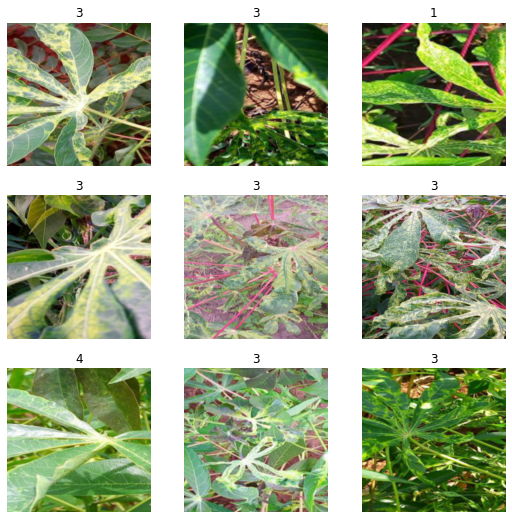

In [11]:
if TEST:
  test = get_data(labels, bs=wandb.config.BATCH_SIZE)
  test.show_batch()

In [12]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
        os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/resnet18/resnet18-5c106cde.pth' '/root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth'

Note the `WandbCallback` invoked below. For details, read documentation [here](https://docs.fast.ai/callback.wandb.html).

In [13]:
dls = get_data(labels,bs=wandb.config.BATCH_SIZE)
if torch.cuda.device_count() > 0:
    learn = cnn_learner(dls, resnet18, metrics=[accuracy],
                       cbs=[WandbCallback(log_dataset=False,
                                          log_model=True,
                                          n_preds = 9)]).to_fp16() #SaveModelCallback
else:
    learn = cnn_learner(dls, resnet18, metrics=[accuracy],
                        cbs=[WandbCallback(log_dataset=False,
                                          log_model=True, n_preds = 9)]) #SaveModelCallback
learn.freeze()
learn.fit_one_cycle(wandb.config.FROZEN_EPOCHS) #, cbs=[MixUp()])
learn.unfreeze()
learn.fit_one_cycle(wandb.config.UNFROZEN_EPOCHS) #, cbs=[MixUp()])
#learn.fine_tune(10)
#learn.export(f'resnet18-full-fold_{split}')


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,accuracy,time
0,2.737822,2.934294,0.037037,00:05


epoch,train_loss,valid_loss,accuracy,time
0,2.699352,3.272386,0.185185,00:04


As a sample of something slightly "fancier" we can do with `wandb`, let's export a confusion matrix.

This was more challenging than I expected (because of `fastai` and `matplotlib`, not wandb). The `wandb` part is dead simple: `wandb.log({"name" : object})`.

epoch,2
train_loss,2.69935
raw_loss,2.9668
wd_0,0.01
sqr_mom_0,0.99
lr_0,4e-05
mom_0,0.94568
eps_0,1e-05
wd_1,0.01
sqr_mom_1,0.99
lr_1,4e-05


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,▆█▇▆▆▆▅▆▆▆▁▄▆▅▄▅▅▆▅▆
raw_loss,▅█▅▃▄▃▃▆▄▆▁▆▇▂▂▇▅▆▄▅
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▃▇█▇▆▅▃▂▁▁▃▇█▇▆▅▃▂▁
mom_0,█▆▂▁▂▃▄▆▇██▆▂▁▂▃▄▆▇█
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▃▇█▇▆▅▃▂▁▁▃▇█▇▆▅▃▂▁


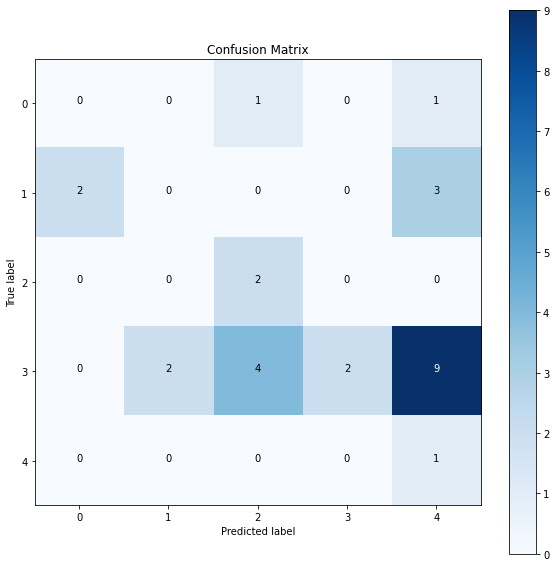

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

cm = interp.confusion_matrix()
fig = plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, "{:,}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")


wandb.log({"conf_mat" : fig})

wandb.finish()